<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Explore_NormAndLightingBatchTransformsGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# colab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
# colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#colab
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [4]:
#colab
# VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [5]:
# colab
!pip install fastai2 --upgrade > /dev/null
!pip freeze | grep fastai2

fastai2==0.0.18


In [6]:
#colab
!pip install git+https://github.com/butchland/fastai_xla_extensions > /dev/null
!pip freeze | grep fastai_xla_extensions

  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-9kxd1ru7


In [7]:
#colab
!pip install git+https://github.com/butchland/my_timesaver_utils > /dev/null
!pip freeze | grep my_timesaver_utils

  Running command git clone -q https://github.com/butchland/my_timesaver_utils /tmp/pip-req-build-wo9czjfq


### Import Libraries

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
from fastai_xla_extensions.core import *

In [10]:
from fastai2.vision.all import *

In [11]:
from my_timesaver_utils.profiling import *

### Setup data

In [12]:
path = untar_data(URLs.PETS)/'images'

### Loop through batch and walk through batch transforms

In [13]:
# from IPython.core.debugger import set_trace

In [14]:
# TRACE = True

In [15]:
orig_randtransform_call = RandTransform.__call__
def __call__(self, b, split_idx=None, **kwargs):
    is_lighting_tfm = isinstance(self, LightingTfm) 
    if is_lighting_tfm:
#         print(f'applying AffineCoordTfm call {self}')
#         if TRACE: set_trace()
        start_record('lighting_tfm_call')
    results = orig_randtransform_call(self, b, split_idx, **kwargs)
    if is_lighting_tfm:
        end_record('lighting_tfm_call')
    return results

In [16]:
setattr(RandTransform,'__call__', __call__)

In [17]:
# orig_normalize_encodes = Normalize.encodes

# def encodes(self, x:TensorImage):
#     start_record('normalize_encodes')
#     results = orig_normalize_encodes(self,x)
#     end_record('normalize_encodes')
#     return results

In [18]:
# setattr(Normalize,'encodes', encodes)

In [19]:
# def mycompose_tfms(x, tfms, is_enc=True, reverse=False, **kwargs):
#     "Apply all `func_nm` attribute of `tfms` on `x`, maybe in `reverse` order"
#     if reverse: tfms = reversed(tfms)
#     for f in tfms:
#         if not is_enc: f = f.decode
#         if isinstance(f,AffineCoordTfm): 
#             print(f'applying {type(f)} {f} to {type(x)}')
#             if TRACE:
#                 set_trace()
#         x = f(x, **kwargs)
#     return x


In [20]:
# @patch_to(Pipeline)
# def __call__(self, o): return mycompose_tfms(o, tfms=self.fs, split_idx=self.split_idx)

In [21]:
# TRACE = False

In [22]:
batch_tfms = [*aug_transforms(max_zoom=1.0, max_warp=0., max_rotate=0., max_lighting=0.2,do_flip=False)]
batch_tfms

[LightingTfm: (TensorImage,object) -> encodes ]

In [23]:
batch_tfms[0].fs

(#2) [<fastai2.vision.augment._BrightnessLogit object at 0x7f24239b1978>,<fastai2.vision.augment._ContrastLogit object at 0x7f24239b19e8>]

In [24]:
pat = r'(.+)_\d+.jpg$'

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [25]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(pat),'name'),
    item_tfms=Resize(224),
    batch_tfms=batch_tfms
   
)

In [26]:
print_prof_data()

In [27]:
datablock.summary(path)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/keeshond_181.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=333x500
  Pipeline: partial -> Categorize
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/keeshond_181.jpg
    applying partial gives
      keeshond
    applying Categorize gives
      TensorCategory(24)

Final sample: (PILImage mode=RGB size=333x500, TensorCategory(24))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> LightingTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=333x500, TensorCategory(24))
    applying Resize gives
   

In [28]:
print_prof_data()

Function lighting_tfm_call called 2 times.
Execution time max: 0.065, average: 0.033


### Setup DataLoaders

In [29]:
bs=256

In [30]:
dls = datablock.dataloaders(path,bs=bs)

In [31]:
dls.device

device(type='cuda', index=0)

In [32]:
dls.train

In [33]:
train_dl = dls.train

In [34]:
train_dl.device

device(type='cuda', index=0)

In [35]:
# def fetch_one_batch():
#     if TRACE: set_trace()
#     dl_iter = train_dl.__iter__()
#     b = dl_iter.__next__()

In [36]:
# TRACE = False

In [37]:
clear_prof_data();print_prof_data()

In [38]:
# fetch_one_batch()

In [39]:
# print_prof_data()

In [40]:
clear_prof_data(); print_prof_data()

In [41]:
def fetch_all_batches():
    for b in train_dl:
        pass

In [42]:
fetch_all_batches()

In [43]:
print_prof_data()

Function lighting_tfm_call called 23 times.
Execution time max: 0.034, average: 0.007


In [44]:
times = get_prof_data('lighting_tfm_call')

In [45]:
# times2 = get_prof_data('normalize_encodes')

In [46]:
import matplotlib.pyplot as plt

In [47]:
times

[0.03354525566101074,
 0.010464191436767578,
 0.003337860107421875,
 0.0029904842376708984,
 0.0027785301208496094,
 0.0031538009643554688,
 0.003044605255126953,
 0.0029404163360595703,
 0.0027670860290527344,
 0.006046772003173828,
 0.0038373470306396484,
 0.0027108192443847656,
 0.0028047561645507812,
 0.012087345123291016,
 0.002945423126220703,
 0.007991552352905273,
 0.015125513076782227,
 0.003338336944580078,
 0.0031206607818603516,
 0.013948678970336914,
 0.009888172149658203,
 0.0031495094299316406,
 0.001965045928955078]

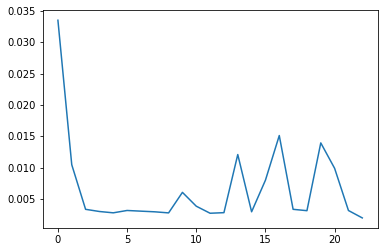

In [48]:
plt.plot(times);

In [49]:
# times2

In [50]:
# plt.plot(times2);